In [1]:
import cv2
import os
import shutil
import numpy as np
import pyautogui
import json

<h1>HoloControl System</h1>

<h2>Hand Detection Model<h2>

In [2]:
with open('dataset1/training_xyz.json') as f:
    xyz = np.array(json.load(f))
    # (N, 21, 3)

with open('dataset1/training_K.json') as f:
    K = np.array(json.load(f))
    # (N, 3, 3)

keypoints_dict = {}

for idx in range(len(xyz)):
    joints_3d = xyz[idx] # (21, 3)
    cam_K = K[idx]       # (3, 3)

    uv = []
    for point in joints_3d:
        x, y, z = point
        px = (cam_K[0][0] * x + cam_K[0][2] * z) / z
        py = (cam_K[1][1] * y + cam_K[1][2] * z) / z
        uv.append([px, py])

    uv = np.array(uv)
    
    uv[:, 0] = uv[:, 0] / 224
    uv[:, 1] = uv[:, 1] / 224
    uv = uv * 128
    keypoints_dict[f"{idx:08d}.jpg"] = uv.flatten().tolist()

In [3]:
import os
print("Number of images:", len(os.listdir('dataset1/training/rgb')))
print("Number of keypoints:", len(xyz))
print("Number of K:", len(K))
import torch
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Number of images: 130240
Number of keypoints: 32560
Number of K: 32560
Device: cuda


In [33]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

# Dataset Preparation
class HandPoseDataset(Dataset):
    def __init__(self, image_dir, keypoints_dict, image_list):
        self.image_dir = image_dir
        self.keypoints_dict = keypoints_dict
        self.image_list = image_list

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        img = img.astype(np.float32) / 255.0
        img = np.transpose(img, (2, 0, 1))  # (C, H, W)
        keypoints = np.array(self.keypoints_dict[img_name], dtype=np.float32)
        keypoints /= 128.0
        return torch.tensor(img, dtype=torch.float32), torch.tensor(keypoints, dtype=torch.float32)

images = [img for img in sorted(os.listdir('dataset1/training/rgb')) if img.endswith('.jpg') and img in keypoints_dict]
print("Total images:", len(images))
print("Total keypoints:", len(keypoints_dict))

dataset = HandPoseDataset('dataset1/training/rgb', keypoints_dict, images)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
print(dataset[0][1]) 

# CNN Model 
class HandPoseCNN(nn.Module):
    def __init__(self):
        super(HandPoseCNN, self).__init__()
        self.features = nn.Sequential(
            # nn.Conv2d(3, 32, kernel_size=3),     # 126x126
            # nn.ReLU(),
            # nn.MaxPool2d(2),                     # 63x63
            # nn.Conv2d(32, 64, kernel_size=3),    # 61x61
            # nn.ReLU(),
            # nn.MaxPool2d(2),                     # 30x30
            # nn.Conv2d(64, 32, kernel_size=3),    # 28x28
            # nn.ReLU(),
            # nn.Flatten()
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),    # 128, 64
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),   # 64, 32
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 32, 16
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.ReLU(), nn.MaxPool2d(2), # 16, 8
            nn.Flatten(),
            nn.Linear(256*8*8, 512), nn.ReLU(),
            nn.Linear(512, 42)
        )

        # Dynamically computing flattened size
    #     self.flattened_size = self._get_flattened_size()
    #     self.fc1 = nn.Linear(self.flattened_size, 512)
    #     self.fc2 = nn.Linear(512, 42)

    # def _get_flattened_size(self):
    #     with torch.no_grad():
    #         dummy = torch.zeros(1, 3, 128, 128)
    #         out = self.features(dummy)
    #         return out.view(1, -1).shape[1]

    def forward(self, x):
        # x = self.features(x)
        # x = self.fc1(x)
        # x = self.fc2(x)

        return self.features(x)

# Training CNN Model
model = HandPoseCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# if os.path.exists("best_hand_model.pth"):
#     model.load_state_dict(torch.load("best_hand_model.pth"))
#     print("✅ Loaded saved model!")
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

best_val_loss = float('inf')
patience = 5
epochs_no_improve = 0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for imgs, keypoints in train_loader:
        imgs, keypoints = imgs.to(device), keypoints.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, keypoints)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * imgs.size(0)

    train_loss /= len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for imgs, keypoints in val_loader:
            imgs, keypoints = imgs.to(device), keypoints.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, keypoints)
            val_loss += loss.item() * imgs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_hand_model.pth")
        print("✅ Saved new best model.")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("⏹️ Early stopping.")
            break


Total images: 32560
Total keypoints: 32560
tensor([0.5870, 0.4175, 0.5145, 0.3753, 0.4727, 0.3776, 0.4219, 0.4164, 0.3526,
        0.4645, 0.4546, 0.4703, 0.4115, 0.4994, 0.3769, 0.5178, 0.3526, 0.5465,
        0.4338, 0.5319, 0.3867, 0.5725, 0.3501, 0.6014, 0.3297, 0.6432, 0.4266,
        0.5675, 0.3813, 0.5981, 0.3402, 0.6290, 0.3092, 0.6603, 0.4168, 0.5866,
        0.3776, 0.6251, 0.3431, 0.6572, 0.3219, 0.6954])
Epoch [1/20] | Train Loss: 0.0096 | Val Loss: 0.0052
✅ Saved new best model.
Epoch [2/20] | Train Loss: 0.0047 | Val Loss: 0.0043
✅ Saved new best model.
Epoch [3/20] | Train Loss: 0.0040 | Val Loss: 0.0038
✅ Saved new best model.
Epoch [4/20] | Train Loss: 0.0035 | Val Loss: 0.0034
✅ Saved new best model.
Epoch [5/20] | Train Loss: 0.0031 | Val Loss: 0.0031
✅ Saved new best model.
Epoch [6/20] | Train Loss: 0.0028 | Val Loss: 0.0029
✅ Saved new best model.
Epoch [7/20] | Train Loss: 0.0026 | Val Loss: 0.0028
✅ Saved new best model.
Epoch [8/20] | Train Loss: 0.0024 | Val L

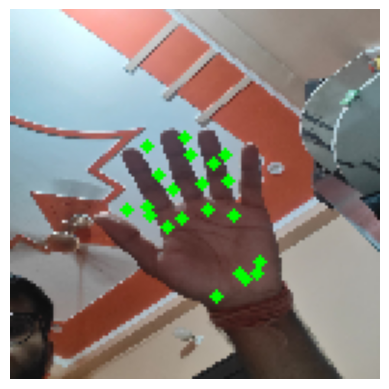

In [ ]:
# model = HandPoseCNN()  # same architecture
# model.load_state_dict(torch.load("best_hand_model.pth"))
# model.to(device)
# model.eval()  # Set to evaluation mode

import matplotlib.pyplot as plt

def predict_single_image(image_path, model):
    img = cv2.imread(image_path)
    img_resized = cv2.resize(img, (128, 128))
    img_normalized = img_resized.astype(np.float32) / 255.0
    img_tensor = torch.tensor(np.transpose(img_normalized, (2, 0, 1)), dtype=torch.float32).unsqueeze(0).to(device)

    with torch.no_grad():
        prediction = model(img_tensor).cpu().numpy().reshape(-1, 2)  # (21, 2)

    return img_resized, prediction


def visualize_keypoints(img, keypoints):
    h, w = img.shape[:2]  # should be 128x128
    for i, (x, y) in enumerate(keypoints):
        px = int(x * w)
        py = int(y * h)
        cv2.circle(img, (px, py), 2, (0, 255, 0), -1)
        # cv2.putText(img, str(i), (px, py), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

image_path = "./heo.jpeg"  # replace with any image you want
img, keypoints = predict_single_image(image_path, model)
visualize_keypoints(img, keypoints)

dummy_input = torch.randn(1, 3, 128, 128).to(device)
torch.onnx.export(model, dummy_input, "handpose_model.onnx", input_names=["input"], output_names=["keypoints"])


<h2>Hand Detection real time using mediapipe</h2>

In [ ]:
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

cap = cv2.VideoCapture(0)

with mp_hands.Hands(max_num_hands = 2, min_detection_confidence = 0.7, min_tracking_confidence = 0.6) as hands:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break
          
        image = cv2.flip(image, 1)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = hands.process(image_rgb)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)
        
        cv2.imshow("HoloControl - Hand Detection", image)

        if cv2.waitKey(1) & 0xFF == 27:
            break

cap.release()
cv2.destroyAllWindows()

I0000 00:00:1751745468.782101  349570 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1751745468.784327  369013 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8-1~bpo12+1pop1~1744225826~22.04~b077665), renderer: Mesa Intel(R) UHD Graphics (ADL-S GT0.5)
W0000 00:00:1751745468.807361  369002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1751745468.824271  368999 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


<h2>Dataset preparation for Hand Sign Detection</h2>

In [ ]:
import os
import shutil

main = 'leapGestRecog'
final = 'dataset'

for user_folder in os.listdir(main):
    user_path = os.path.join(main, user_folder)
    
    if not os.path.isdir(user_path):
        continue

    for gesture_folder in os.listdir(user_path):
        gesture_path = os.path.join(user_path, gesture_folder)
        gesture_name = gesture_folder.split("_")[1]
        dest_folder = os.path.join(final, gesture_name)
        os.makedirs(dest_folder, exist_ok=True)
        
        count = 0
        for img in os.listdir(gesture_path):
            src = os.path.join(gesture_path, img)
            new_name = f"{user_folder}_{gesture_name}_{str(count).zfill(3)}.png"
            dst = os.path.join(dest_folder, new_name)
            shutil.copy(src, dst)
            count += 1